
**Q1. Problem Statement: Random Forest** <br>
	Write a Python program that reads the TaxiFare.csv (provided on LMS) file into a DataFrame and build a good random forest model by performing the following tasks:
1.	Load the TaxiFare.csv dataset into a DataFrame
2.	Drop ‘unique_id’, and find missing values from the dataset
3.	Convert the ‘date_time_of_pickup’ column to date and time formate and extract information and create new columns as ‘hour‘, ‘dayOfTheMonth’,’ month’,   ‘dayOfTheWeek’.
4.	Find traveling distance based on given coordinates using the "Haversine" distance formula and create a new column as ‘distance’ and store the data.
5.	Eliminate some anomalous/outlier data based on certain "Domain" logic
A. Amount < 2.5 as the minimum fare is 2.5
B. Trips with travel distance less than or equal to 1, and more than 130Kms. Let’s say this was a condition provided by clients based on travel range.
6.	Extract independent variables (Xs) and dependent variables (Ys) into separate data objects
7.	Find important features using random forest.
8.	Build a model and predict the result for the test dataset based on MAPE and RMSE.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from statsmodels.api import add_constant, OLS
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import plot_tree
from sklearn.metrics import accuracy_score
from io import StringIO

##**STEP1:**
Load tha dataset

In [2]:
df = pd.read_csv("/content/sample_data/TaxiFare.csv")

In [3]:
df.head()

,unique_id,date_time_of_pickup,longitude_of_pickup,latitude_of_pickup,longitude_of_dropoff,latitude_of_dropoff,no_of_passenger,amount
0,26:21.0,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1,4.5
1,52:16.0,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1,16.9
2,35:00.0,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2,5.7
3,30:42.0,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1,7.7
4,51:00.0,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1,5.3


##**STEP2:**
Drop unwanted columns from dataset

In [4]:
df = df.drop("unique_id",axis = 1)

In [7]:
df.isna().sum()

date_time_of_pickup     0
longitude_of_pickup     0
latitude_of_pickup      0
longitude_of_dropoff    0
latitude_of_dropoff     0
no_of_passenger         0
amount                  0
dtype: int64

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype              
---  ------                --------------  -----              
 0   date_time_of_pickup   50000 non-null  datetime64[ns, UTC]
 1   longitude_of_pickup   50000 non-null  float64            
 2   latitude_of_pickup    50000 non-null  float64            
 3   longitude_of_dropoff  50000 non-null  float64            
 4   latitude_of_dropoff   50000 non-null  float64            
 5   no_of_passenger       50000 non-null  int64              
 6   amount                50000 non-null  float64            
dtypes: datetime64[ns, UTC](1), float64(5), int64(1)
memory usage: 2.7 MB


##**STEP3:**
Making tha new features based on old features

In [5]:
df["date_time_of_pickup"] = pd.to_datetime(df["date_time_of_pickup"])
new_df = df.assign(hour = df["date_time_of_pickup"].dt.hour, dayOfTheMonth = df["date_time_of_pickup"].dt.day, month = df["date_time_of_pickup"].dt.month, dayOfTheWeek = df["date_time_of_pickup"].dt.dayofweek)
new_df.drop("date_time_of_pickup", axis = 1, inplace = True)
new_df.head()

,longitude_of_pickup,latitude_of_pickup,longitude_of_dropoff,latitude_of_dropoff,no_of_passenger,amount,hour,dayOfTheMonth,month,dayOfTheWeek
0,-73.844311,40.721319,-73.841610,40.712278,1,4.5,17,15,6,0
1,-74.016048,40.711303,-73.979268,40.782004,1,16.9,16,5,1,1
2,-73.982738,40.761270,-73.991242,40.750562,2,5.7,0,18,8,3
3,-73.987130,40.733143,-73.991567,40.758092,1,7.7,4,21,4,5
4,-73.968095,40.768008,-73.956655,40.783762,1,5.3,7,9,3,1


##**STEP4:**
 Find traveling distance based on given coordinates using "Haversine" distance formula.

In [9]:
def haversine_np(lon1, lat1, lon2, lat2):
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c # 6367 is radius of earth in kilometers.
    return km
new_df["distance"] = haversine_np(new_df["longitude_of_pickup"], new_df["latitude_of_pickup"], new_df["longitude_of_dropoff"], new_df["latitude_of_dropoff"])
new_df.head()

,longitude_of_pickup,latitude_of_pickup,longitude_of_dropoff,latitude_of_dropoff,no_of_passenger,amount,hour,dayOfTheMonth,month,dayOfTheWeek,distance
0,-73.844311,40.721319,-73.841610,40.712278,1,4.5,17,15,6,0,1.030117
1,-74.016048,40.711303,-73.979268,40.782004,1,16.9,16,5,1,1,8.444828
2,-73.982738,40.761270,-73.991242,40.750562,2,5.7,0,18,8,3,1.388653
3,-73.987130,40.733143,-73.991567,40.758092,1,7.7,4,21,4,5,2.797513
4,-73.968095,40.768008,-73.956655,40.783762,1,5.3,7,9,3,1,1.997902


In [11]:
new_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
longitude_of_pickup,50000.0,-72.509756,10.393860,-75.423848,-73.992062,-73.981840,-73.967148,40.783472
latitude_of_pickup,50000.0,39.933759,6.224857,-74.006893,40.734880,40.752678,40.767360,401.083332
longitude_of_dropoff,50000.0,-72.504616,10.407570,-84.654241,-73.991152,-73.980082,-73.963584,40.851027
latitude_of_dropoff,50000.0,39.926251,6.014737,-74.006377,40.734372,40.753372,40.768167,43.415190
no_of_passenger,50000.0,1.667840,1.289195,0.000000,1.000000,1.000000,2.000000,6.000000
amount,50000.0,11.364171,9.685557,-5.000000,6.000000,8.500000,12.500000,200.000000
hour,50000.0,13.489080,6.506935,0.000000,9.000000,14.000000,19.000000,23.000000
dayOfTheMonth,50000.0,15.672040,8.660789,1.000000,8.000000,16.000000,23.000000,31.000000
month,50000.0,6.273300,3.461157,1.000000,3.000000,6.000000,9.000000,12.000000
dayOfTheWeek,50000.0,3.029980,1.956936,0.000000,1.000000,3.000000,5.000000,6.000000


In [12]:
print(new_df["amount"].describe())
fullRaw = new_df[new_df["amount"] >= 2.5]
print(new_df["amount"].describe())

count    50000.000000
mean        11.364171
std          9.685557
min         -5.000000
25%          6.000000
50%          8.500000
75%         12.500000
max        200.000000
Name: amount, dtype: float64
count    50000.000000
mean        11.364171
std          9.685557
min         -5.000000
25%          6.000000
50%          8.500000
75%         12.500000
max        200.000000
Name: amount, dtype: float64


In [13]:
print(new_df["distance"].describe())
new_df = new_df[(new_df["distance"] >= 1) & (new_df["distance"] <= 130)]
print(new_df["distance"].describe())

count    50000.000000
mean        18.497326
std        355.341070
min          0.000000
25%          1.222378
50%          2.118783
75%          3.893124
max       8662.376766
Name: distance, dtype: float64
count    40926.000000
mean         3.919168
std          4.491177
min          1.000150
25%          1.662453
50%          2.576932
75%          4.490593
max        129.868894
Name: distance, dtype: float64


In [14]:
new_df.shape

(40926, 11)

##**Step5:**
Extract independent variables (Xs) and dependent variables (Ys) into separate data objects

In [15]:
x = new_df.drop(["amount"], axis = 1).copy()
y = new_df["amount"].copy()
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size = 0.20,random_state=100)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(32740, 10)
(8186, 10)
(32740,)
(8186,)


##**STEP6:**
Model building

In [16]:
from sklearn.ensemble import RandomForestRegressor

In [17]:
M1 = RandomForestRegressor(random_state=123)
M1 = M1.fit(x_train,y_train)


**Step-6:** Feature importance

In [18]:
varImpDf = pd.DataFrame()
varImpDf["Importance"] = M1.feature_importances_
varImpDf["Variable"] = x_train.columns
varImpDf.sort_values("Importance", ascending = False, inplace = True)

varImpDf.head()

,Importance,Variable
9,0.833108,distance
2,0.046062,longitude_of_dropoff
3,0.033203,latitude_of_dropoff
0,0.026619,longitude_of_pickup
1,0.019757,latitude_of_pickup


**Step-7:** Prediction on test data

In [19]:
testPredDf = pd.DataFrame()

testPredDf["Prediction"] = M1.predict(x_test)

# Create a column to store actuals
testPredDf["Actual"] = y_test.values

# Validate if the above worked
testPredDf.head()

,Prediction,Actual
0,13.2817,15.5
1,9.1810,10.0
2,8.3820,8.0
3,6.1400,5.0
4,15.7530,21.0


**Step-8:** evaluate score based on RMSE and MAPE

In [20]:
# RMSE
print("RMSE",np.sqrt(np.mean((testPredDf["Actual"] - testPredDf["Prediction"])**2)))
# This means on an "average", the taxi fare prediction would have +/- error of about $4.24
# Lower the RMSE, better the model prediction

# MAPE
print("MAPE",(np.mean(np.abs(((testPredDf["Actual"] - testPredDf["Prediction"])/testPredDf["Actual"]))))*100)
# This means on an "average", the taxi fare prediction would have +/- error of ~18%
# Lower the MAPE, better the model prediction

RMSE 4.249447879749447
MAPE 18.924176905704467


**Q2. Problem Statement: Performance Measurements**<br>
Write a Python program that reads the h1n1_vaccine_prediction.csv (provided on LMS) file into a DataFrame and build a good random forest model by performing the following tasks:
1.	Load the h1n1_vaccine_prediction.csv dataset into a DataFrame
2.	Do value count for the dependent variable, and check data is imbalanced or not.
3.	Drop columns that have more than 50% missing data. And then drop all null values
4.	Print a Bar plot for the dependent variable for all categories
5.	Do label encoding for all categorical features
6.	Extract independent variables (Xs) and dependent variables (Ys) into separate data objects
7.	Build a random forest model evaluate on test data.
8.	Do oversample and then build another random forest model for test data and compare their accuracy.


**STEP-1:**Importing libraries

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing  import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from imblearn.over_sampling import SMOTE
from matplotlib.colors import ListedColormap
from sklearn import metrics
import seaborn as sns

**Step-2:**  Load data set into dataframe.

In [22]:
df1 = pd.read_csv("/content/sample_data/h1n1_vaccine_prediction.csv")

In [23]:
df1.head()

,unique_id,h1n1_worry,h1n1_awareness,antiviral_medication,contact_avoidance,bought_face_mask,wash_hands_frequently,avoid_large_gatherings,reduced_outside_home_cont,avoid_touch_face,...,race,sex,income_level,marital_status,housing_status,employment,census_msa,no_of_adults,no_of_children,h1n1_vaccine
0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,White,Female,Below Poverty,Not Married,Own,Not in Labor Force,Non-MSA,0.0,0.0,0
1,1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,...,White,Male,Below Poverty,Not Married,Rent,Employed,"MSA, Not Principle City",0.0,0.0,0
2,2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,White,Male,"<= $75,000, Above Poverty",Not Married,Own,Employed,"MSA, Not Principle City",2.0,0.0,0
3,3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,...,White,Female,Below Poverty,Not Married,Rent,Not in Labor Force,"MSA, Principle City",0.0,0.0,0
4,4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,...,White,Female,"<= $75,000, Above Poverty",Married,Own,Employed,"MSA, Not Principle City",1.0,0.0,0


In [24]:
df1.shape

(26707, 34)

**Step-3:**  Data distribution of target variable.

In [25]:
df1.h1n1_vaccine.value_counts()

0    21033
1     5674
Name: h1n1_vaccine, dtype: int64

**Step-4:**  Missing value analysis.

In [26]:
df1.isnull().sum()/len(df1)*100

unique_id                     0.000000
h1n1_worry                    0.344479
h1n1_awareness                0.434343
antiviral_medication          0.265848
contact_avoidance             0.778822
bought_face_mask              0.071142
wash_hands_frequently         0.157262
avoid_large_gatherings        0.325757
reduced_outside_home_cont     0.307036
avoid_touch_face              0.479275
dr_recc_h1n1_vacc             8.087767
dr_recc_seasonal_vacc         8.087767
chronic_medic_condition       3.635751
cont_child_undr_6_mnths       3.070356
is_health_worker              3.010447
has_health_insur             45.957989
is_h1n1_vacc_effective        1.464036
is_h1n1_risky                 1.452803
sick_from_h1n1_vacc           1.479013
is_seas_vacc_effective        1.729884
is_seas_risky                 1.924589
sick_from_seas_vacc           2.010709
age_bracket                   0.000000
qualification                 5.268282
race                          0.000000
sex                      

In [27]:
df1 = df1.drop("has_health_insur",axis = 1)
df1 = df1.dropna()
df1.shape

(19642, 33)

**Step-5:**  check balance of target variable

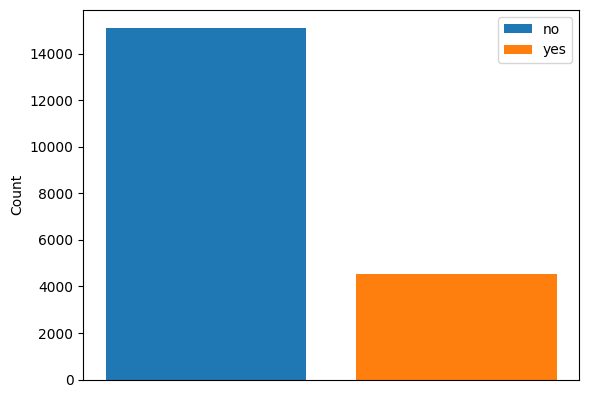

In [28]:
#Is Data Balanced?
purchased=df1[df1.h1n1_vaccine==0].h1n1_vaccine.count()
notpurchased=df1[df1.h1n1_vaccine==1].h1n1_vaccine.count()
plt.bar(0,purchased,label='no')
plt.bar(1,notpurchased,label='yes')
plt.xticks([])
plt.ylabel('Count')
plt.legend()
plt.show()

In [29]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19642 entries, 0 to 26706
Data columns (total 33 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   unique_id                  19642 non-null  int64  
 1   h1n1_worry                 19642 non-null  float64
 2   h1n1_awareness             19642 non-null  float64
 3   antiviral_medication       19642 non-null  float64
 4   contact_avoidance          19642 non-null  float64
 5   bought_face_mask           19642 non-null  float64
 6   wash_hands_frequently      19642 non-null  float64
 7   avoid_large_gatherings     19642 non-null  float64
 8   reduced_outside_home_cont  19642 non-null  float64
 9   avoid_touch_face           19642 non-null  float64
 10  dr_recc_h1n1_vacc          19642 non-null  float64
 11  dr_recc_seasonal_vacc      19642 non-null  float64
 12  chronic_medic_condition    19642 non-null  float64
 13  cont_child_undr_6_mnths    19642 non-null  flo

**Step-6:**  Do label encoding for each catagorical data.

In [30]:
from sklearn import preprocessing
df1.age_bracket.unique() # we need to replce age bracate with labes
le = preprocessing.LabelEncoder()
df1['age_bracket'] = le.fit_transform(df1.age_bracket.values)
df1['age_bracket']

0        3
1        1
3        4
4        2
5        4
        ..
26700    3
26701    0
26702    4
26703    0
26706    4
Name: age_bracket, Length: 19642, dtype: int64

In [31]:
df1.qualification = le.fit_transform(df1.qualification.values)
df1.qualification

0        1
1        0
3        0
4        3
5        0
        ..
26700    0
26701    2
26702    3
26703    2
26706    3
Name: qualification, Length: 19642, dtype: int64

In [32]:
df1.race = le.fit_transform(df1.race.values)
df1.sex = le.fit_transform(df1.sex.values)
df1.income_level = le.fit_transform(df1.income_level.values)
df1.marital_status = le.fit_transform(df1.marital_status.values)
df1.housing_status = le.fit_transform(df1.housing_status.values)
df1.employment = le.fit_transform(df1.employment.values)
df1.census_msa = le.fit_transform(df1.census_msa.values)
df1

,unique_id,h1n1_worry,h1n1_awareness,antiviral_medication,contact_avoidance,bought_face_mask,wash_hands_frequently,avoid_large_gatherings,reduced_outside_home_cont,avoid_touch_face,...,race,sex,income_level,marital_status,housing_status,employment,census_msa,no_of_adults,no_of_children,h1n1_vaccine
0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,3,0,2,1,0,1,2,0.0,0.0,0
1,1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,...,3,1,2,1,1,0,0,0.0,0.0,0
3,3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,...,3,0,2,1,1,1,1,0.0,0.0,0
4,4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,...,3,0,0,0,0,0,0,1.0,0.0,0
5,5,3.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,3,1,0,0,0,0,1,2.0,3.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26700,26700,3.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,3,0,1,0,0,1,1,1.0,0.0,0
26701,26701,2.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,3,0,1,1,1,1,1,3.0,0.0,0
26702,26702,2.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,3,0,0,1,0,1,2,0.0,0.0,0
26703,26703,1.0,2.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,3,1,0,1,1,0,1,1.0,0.0,0


**Step-7:** Extract independent variables (Xs) and dependent variables (Ys) into separate data objects

In [33]:
x= df1.drop("h1n1_vaccine",axis = 1)
y= df1['h1n1_vaccine']

**Step-8:** Model building before applying SMOTE

In [34]:
x_train,x_test,y_train,y_test=train_test_split(x, y,test_size=0.20)
clf = RandomForestClassifier(n_estimators = 100)
clf.fit(x_train, y_train)

# performing predictions on the test dataset
y_pred = clf.predict(x_test)

# metrics are used to find accuracy or error
from sklearn import metrics
print()
score1 = metrics.accuracy_score(y_test, y_pred)
# using metrics module for accuracy calculation
print("ACCURACY OF THE MODEL: ", metrics.accuracy_score(y_test, y_pred))


ACCURACY OF THE MODEL:  0.8261644184270807


**Step-9:** Model building after applying SMOTE

In [35]:
#Over sampling the dataset
from imblearn.over_sampling import SMOTE
oversample = SMOTE()
x_smot, y_smot = oversample.fit_resample(x, y)

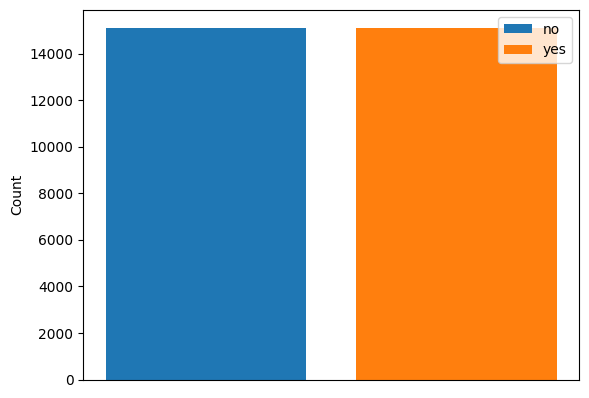

In [36]:
# after smot all class are equale.
purchased=y_smot[y_smot==0].count()
notpurchased=y_smot[y_smot==1].count()
plt.bar(0,purchased,label='no')
plt.bar(1,notpurchased,label='yes')
plt.xticks([])
plt.ylabel('Count')
plt.legend()
plt.show()

In [37]:
x_train,x_test,y_train,y_test=train_test_split(x_smot, y_smot,test_size=0.20)

In [39]:
clf = RandomForestClassifier(n_estimators = 100)
clf.fit(x_train, y_train)

# performing predictions on the test dataset
y_pred = clf.predict(x_test)

# metrics are used to find accuracy or error
from sklearn import metrics
print()
score2 =  metrics.accuracy_score(y_test, y_pred)
# using metrics module for accuracy calculation
print("ACCURACY OF THE MODEL: ", metrics.accuracy_score(y_test, y_pred))


ACCURACY OF THE MODEL:  0.8884666226040978


**Step-10:** Comparing both models.

In [40]:
print("before smot accuracy is:",score1)
print("after smot accuracy is:",score2)


before smot accuracy is: 0.8261644184270807
after smot accuracy is: 0.8884666226040978
